## AIM: Calibration script for Diffraction at the the 2200
* poly-crystalline quantifoil gold as reference

In [1]:
## Data Location

# Import all needed packages
import os
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import py4DSTEM
import ase.io
import abtem
import matplotlib
import mplcyberpunk
import scipy
import h5py

# Custom functions used in this script
from cepstral import browser  # Explicitly import the browser function
from Plot_Style import Plot_Style_OM_activate  # Import custom plot style
from User_Functions import ListFilesFormatedSortedByTimeAndFilterForString, PantaRheiConvertHyperspyToPreviewWithScale  # Import custom plot style

# Load custom plot style
Plot_Style_OM_activate(white_bkg_for_visualization=True)

# Uncomment the following line to use cyberpunk style instead
# plt.style.use('cyberpunk')

# Note: This line is specific to Jupyter Notebooks
# Uncomment if running in Jupyter
%matplotlib ipympl

# Print the py4DSTEM version
print(py4DSTEM.__version__)

0.14.17


In [24]:
# Final list

# Base dictionary - in px/Ang - 256x256 images (used binning) - do not use 20cm anyway :D 
cameraLengthDict = {
    "20cm": 0.08, # maybe 
    "25cm": 0.0280, 
    "30cm": 0.0195, 
    "40cm": 0.0149, 
    "50cm": 0.0127, 
    "60cm": 0.0106, 
    "80cm": 0.00845, 
    "100cm": 0.00658, 
    "120cm": 0.00540, 
    "150cm": 0.00450,
}

cameraLengthDict["60cm"]

0.0106

In [2]:
## make list of all desired files
fp = '//masc_shared/ag_volz/Oliver_Maßmeyer/Perovskites/2025_01_22and23/20250122_Perovskite'

goldReferenceList = ListFilesFormatedSortedByTimeAndFilterForString(fp, 'Gold_Reference')


20250122_Perovskite/
    0: Gold_Reference_60cm_CL.hspy
    1: Gold_Reference_50cm_CL.hspy
    2: Gold_Reference_40cm_CL.hspy
    3: Gold_Reference_30cm_CL.hspy
    4: Gold_Reference_25cm_CL.hspy
    5: Gold_Reference_20cm_CL.hspy
    6: Gold_Reference_80cm_CL.hspy
    7: Gold_Reference_100cm_CL.hspy
    8: Gold_Reference_120cm_CL.hspy
    9: Gold_Reference_150cm_CL.hspy
    10: Gold_Reference_150cm_CL_ILstig_adjusted.hspy


In [3]:
%%capture 
## capture magic to suppress the outputs - prevent crashing of the jupyter

#create Folder for preview images
folderName = 'Preview_Single_Aquisition'

# PantaRheiConvertHyperspyToPreviewWithNmScale(folderName, fp, STEM_files, 300, '.tiff')
PantaRheiConvertHyperspyToPreviewWithScale(folderName, fp, goldReferenceList, '.tiff')


In [3]:
plt.close('all')

In [4]:
## make gold reference
#use ASE to import the xyz file

fpCIF = '//masc_shared/ag_volz/Oliver_Maßmeyer/CIF_Files'
# fn_xyz = 'TAPP_3D_preRelax_removeDups_adjustBonds_rot_vac5.2.xyz'
fnCIF = 'Au_mp-81_symmetrized.cif'

filepathCIF = os.path.join(fpCIF,fnCIF)

ase_atoms = ase.io.read(filepathCIF)


Text(0.5, 0.98, 'GOLD Structure')

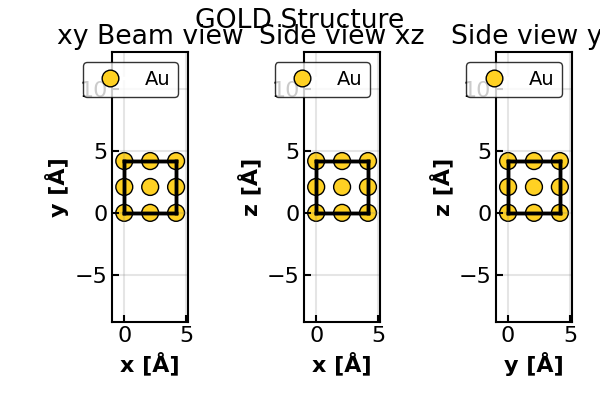

In [5]:
## Use abtem for visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(ase_atoms, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(ase_atoms, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(ase_atoms, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)

fig.tight_layout()
fig.suptitle('GOLD Structure')

This Atoms object contains occupancy information but it will be ignored.


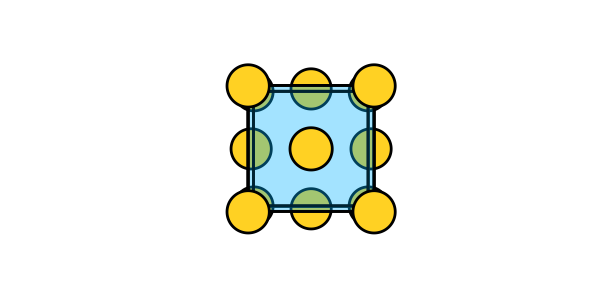

In [6]:
## Convert the Ase cell into py4dstem crystal
crystal = py4DSTEM.process.diffraction.Crystal.from_ase(ase_atoms)

#plot the desired Zone axis
crystal.plot_structure(
    zone_axis_lattice=(0,0,1),
    figsize=(6,3),
    camera_dist = 6,
)

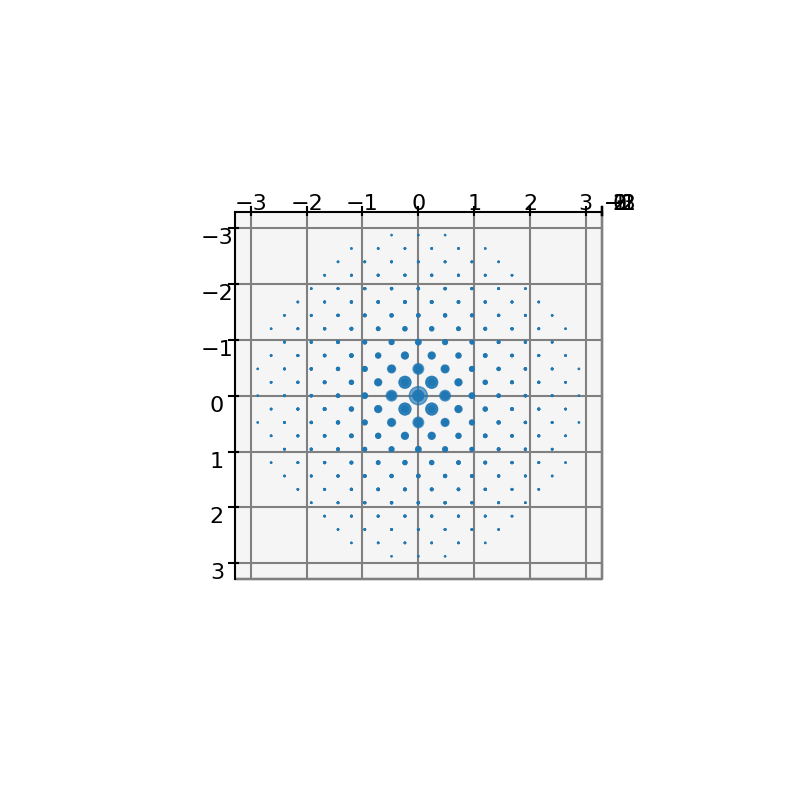

In [7]:
# Calculate structure factors
k_max = 3


(q_SF, I_SF) = crystal.calculate_structure_factors(
    k_max,
    tol_structure_factor = 1e-5,
    return_intensities = True,
)

fig, ax = crystal.plot_structure_factors(zone_axis_lattice=[0,0,1],scale_markers=500, perspective_axes=False,returnfig=True)


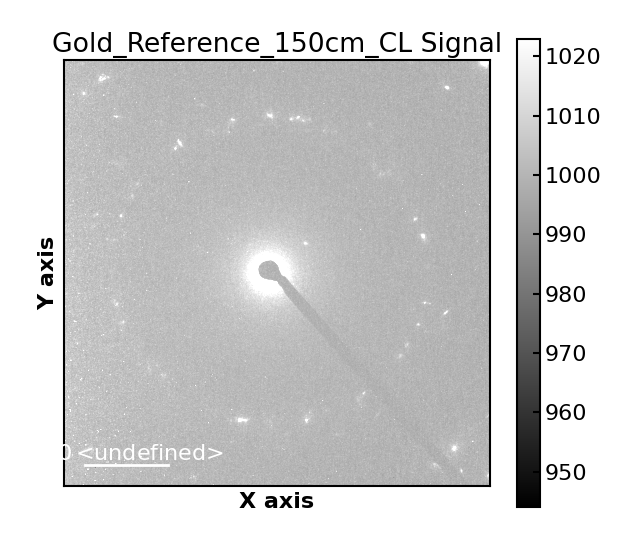

In [430]:
## load the data
fullFileName = os.path.join(fp, goldReferenceList[9])
referenceImage = hs.load(fullFileName)

# #plot the stack 
referenceImage.plot(vmax='99th')


In [431]:
## convert to py4dstem dataset

#reshape to 4D data
data = referenceImage.data
# data = data[np.newaxis,np.newaxis, ...]
data = np.tile(data, (2,2,1,1))


# Load the datacube using py4DSTEM
dataset = py4DSTEM.datacube.DataCube(
    data,
)

In [432]:
dataset.bin_Q(4)

DataCube( A 4-dimensional array of shape (2, 2, 256, 256) called 'datacube',
          with dimensions:

              Rx = [0,1] pixels
              Ry = [0,1] pixels
              Qx = [0,4,8,...] pixels
              Qy = [0,4,8,...] pixels
)

In [272]:
dataset.shape

(2, 2, 256, 256)

overflow encountered in exp


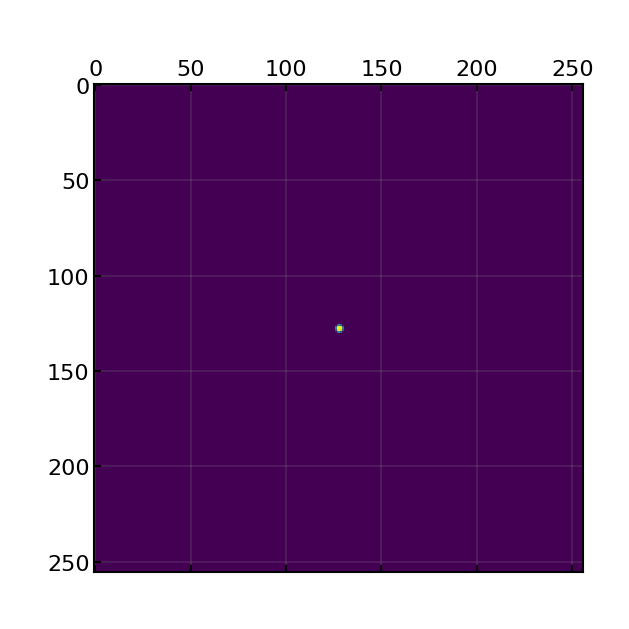

In [433]:
##synthetic probe

probe = py4DSTEM.Probe.generate_synthetic_probe(2, 1, dataset.shape[2:4])
plt.matshow(probe.probe)

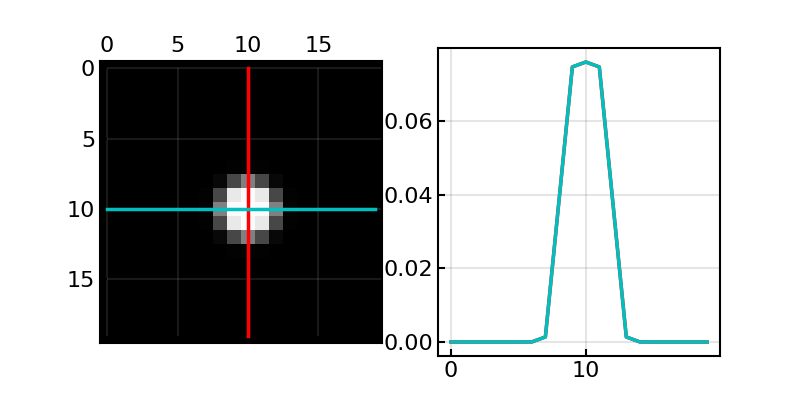

Text(0.5, 1.0, 'Probe Kernel')

In [434]:


# Create the Kernel for Cross Correlation from the Probe image
probe_kernel = probe.get_kernel(
    mode='flat',
    bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R=10, L=10, W=1,
    figsize=(8, 4),
)
plt.title('Probe Kernel')

In [435]:
##Paramters: 
detect_params = {
    'corrPower': 1,
    'sigma': 0,
    'edgeBoundary': 5,
    'minRelativeIntensity': 0.62, #20cm 0.53 #25cm 0.67 #30cm 0.71 #40cm 0.68, #50cm 0.72, CL 60cm 0.62, CL80cm 0.84, CL100cm 0.807, CL120cm 0.858,,  CL150cm 0.937,
    'minAbsoluteIntensity': 16000,
    'minPeakSpacing': 1,
    'subpixel' : 'multicorr',
#     'subpixel' : 'multicorr',
    # 'upsample_factor': 4,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

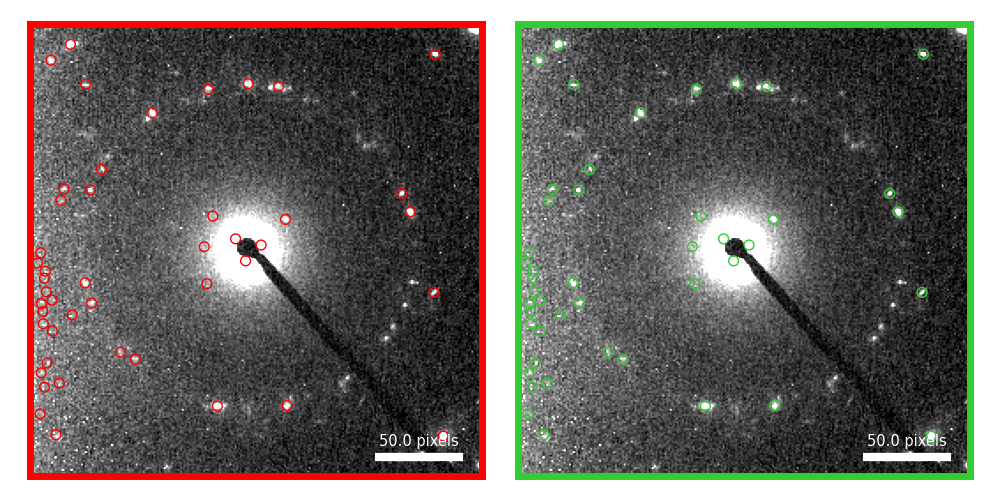

In [446]:
# Test parameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions
colors=['r','limegreen','c','g','orange']
# parameters
detect_params = {
    'corrPower': 1,
    'sigma': 0,
    'edgeBoundary': 5,
    'minRelativeIntensity': 0.937,
    'minAbsoluteIntensity': 16000,
    'minPeakSpacing': 1,
    'subpixel' : 'multicorr',
#     'subpixel' : 'multicorr',
    # 'upsample_factor': 4,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (0, 0),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[0,0,:,:],
    H=1, 
    W=2,
    axsize=(5,5),
    # intensity_range='absolute',
    # vmin=72,
    # vmax=300,
    # scaling='power',
    # power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected.data['qx'],
    get_y = lambda i: disks_selected.data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 50,
)

In [447]:
# Find Bragg peaks for all probe positions
bragg_peaks = dataset.find_Bragg_disks(
    template=probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████| 4.00/4.00 [00:00<00:00, 24.4DP/s]


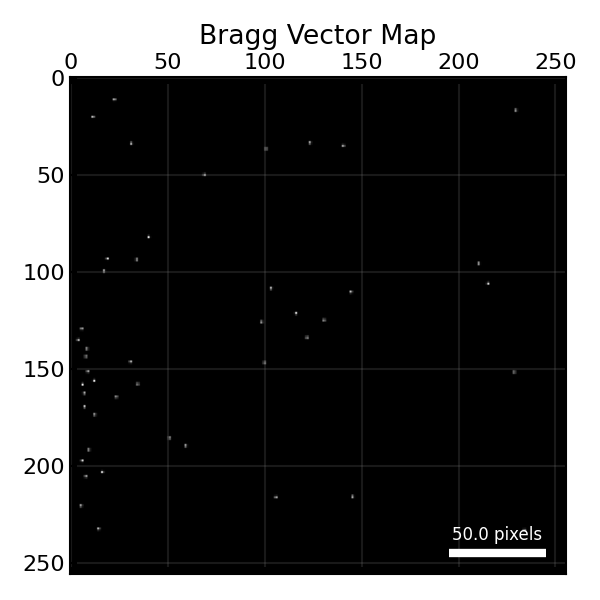

In [448]:
# Visualize: Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm(mode='raw',sampling=1) # sampling needed for visualization

py4DSTEM.show(
    bragg_vector_map_centered,
    figsize=(6,6),
    # scaling='log',
    title='Bragg Vector Map',
    # vmin=1,
)

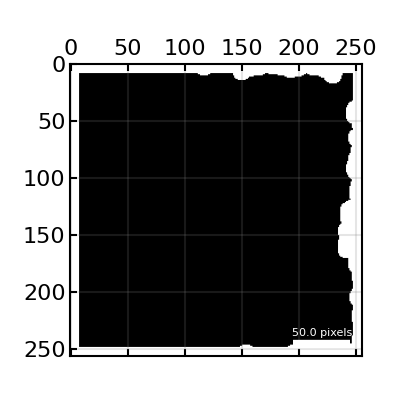

In [449]:
# First, generate a mask of the beamstop, plot it
dataset.get_beamstop_mask(
    threshold = 0.1,
    distance_edge = 8,
    # include_edges=False,
);

py4DSTEM.show(
    dataset.tree("mask_beamstop"),
    intensity_range='absolute',
    vmin=0,
    vmax=1,
    figsize = (4,4),
)

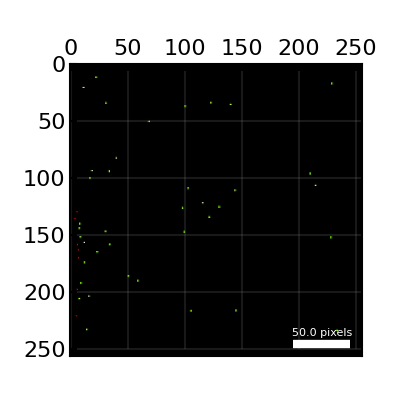

In [450]:
# Apply the mask to the raw bragg peaks
bragg_peaks_masked = bragg_peaks.mask_in_Q(
    dataset.tree("mask_beamstop").data,
)

# Create a bragg vector map (2D histogram of all detected bragg peaks) for both raw and masked Bragg peaks
bragg_vector_map = bragg_peaks.get_bvm(mode='raw',sampling=1)
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw',sampling=1)

# Plot a comparison image between the original and masked bragg vector map
py4DSTEM.show(
    [
        bragg_vector_map, 
        bragg_vector_map_masked,
    ],
    combine_images = True,
    figsize = (4,4),
) 

In [288]:
##some how does not work as wanted --> maybe to small amount of fitting points?

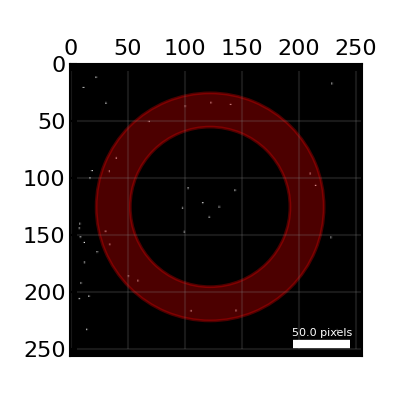

In [456]:
# Guess the center coordinate, specify the radial range for fitting peak pairs



# #CL80cm
# center_guess = (127,119)
# radial_range = (10,45)

# #CL60cm
# center_guess = (126,121)
# radial_range = (95,110)

# #CL50cm
# center_guess = (123,121)
# radial_range = (30,50)

# #CL40cm
# center_guess = (124,120)
# radial_range = (30,50)

# #CL30cm
# center_guess = (123,121)
# radial_range = (25,50)

# #CL25cm
# center_guess = (123,122)
# radial_range = (10,45)

# #CL20cm
# center_guess = (123,122)
# radial_range = (10,45)


# #CL100cm
# center_guess = (127,118)
# radial_range = (60,100)

#CL120cm
center_guess = (125,126)
radial_range = (70,100)

#CL150cm
center_guess = (125,122)
radial_range = (70,100)

# Show the ADF detector, overlaid over a new BVM
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw',sampling=1)
py4DSTEM.show(
    bragg_vector_map_masked, 
    annulus = {
      'center':center_guess,
      'radii' : radial_range,
      'alpha':0.3,
      'fill':True
    },
    figsize = (4,4),
)

## centering and elliptic corretion do not work yet

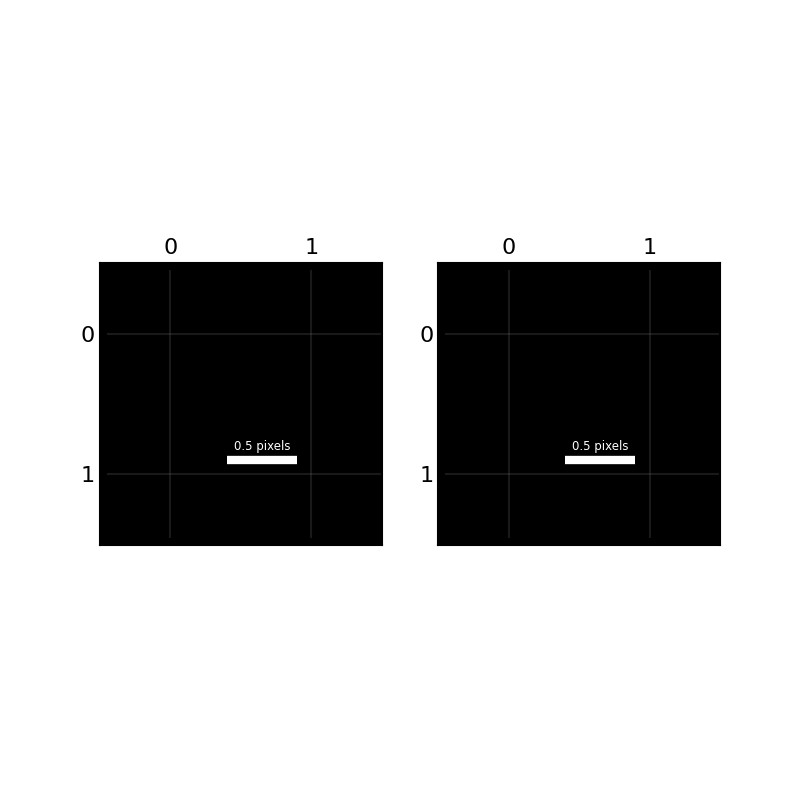

In [124]:
## correct for sampling

# center_guess = (48.5*10,53*10)
# radial_range = (14*10,18*10)


qx0_meas,qy0_meas,mask_originmeas = bragg_peaks_masked.measure_origin_beamstop(
    center_guess = center_guess,
    radii = radial_range,
    max_dist = 3,
    max_iter = 3
)

import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2,figsize=(8,8))
py4DSTEM.show(
    qx0_meas,
    intensity_range='centered',
    vmin = np.mean(qx0_meas[mask_originmeas]),
    cmap = 'RdBu',
    figax = (fig,axs[0]),
    mask = mask_originmeas
)
py4DSTEM.show(
    qy0_meas,
    intensity_range='centered',
    vmin = np.mean(qy0_meas[mask_originmeas]),
    cmap = 'RdBu',
    figax = (fig,axs[1]),
    mask = mask_originmeas
)
plt.show()

Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated


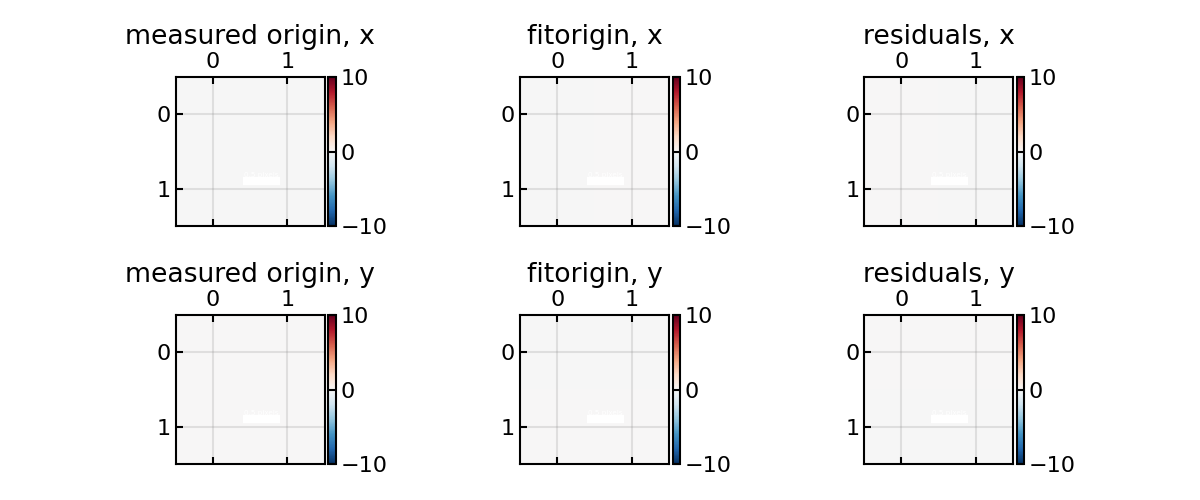

In [102]:
bragg_peaks_masked.measure_origin_beamstop(
    center_guess = center_guess,
    radii = radial_range,
    max_dist = 10,
    max_iter = 3
);
# Note that we store the origins internally here.

# Fit a plane wave to the origins
qx0_fit,qy0_fit,qx0_res,qy0_res = bragg_peaks_masked.fit_origin(
    plot_range = 10,
    axsize = (4,2.5),
);

In [103]:
bragg_peaks_masked.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       4
             R_pixel_size:       1
             Q_pixel_units:      pixels
             R_pixel_units:      pixels
             QR_flip:            False
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           107.21602815726452
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           114.19609408912933
             qy0_shift:          2D-array
)

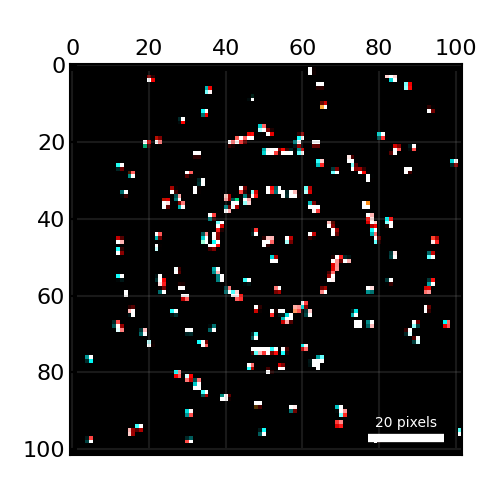

In [388]:
# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks_masked.get_bvm(sampling=0.1)
py4DSTEM.show([bragg_vector_map_masked,bragg_vector_map_centered],combine_images=True)

In [424]:
centerBraggPeaks = bragg_peaks_masked.calibration.get_origin_mean()
centerBraggPeaks[0]

404.0878645309539

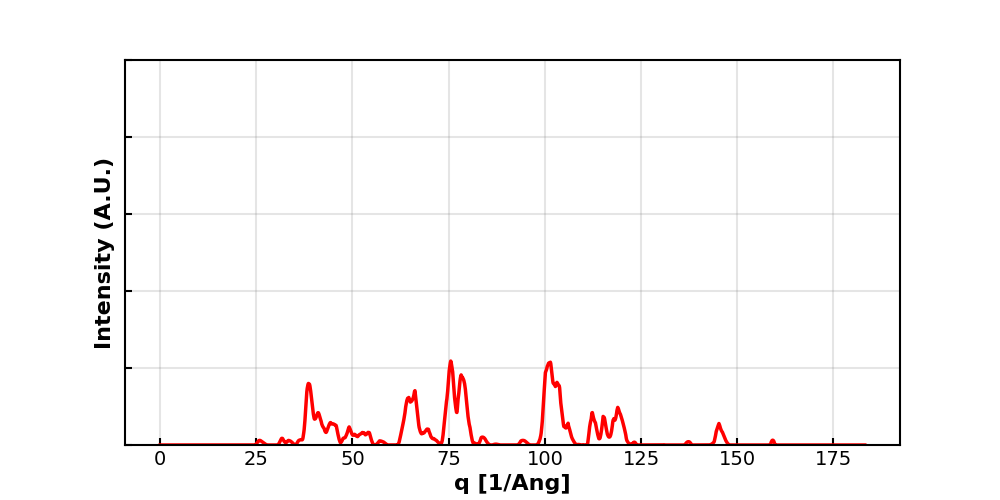

(0.0, 200.0)

In [136]:
# Calculate and plot the radial integral
ymax = 1e8

centerBraggPeaks = bragg_peaks_masked.calibration.get_origin_mean()

q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    # bragg_vector_map_centered,
    bragg_vector_map_masked,
    # x0=centerBraggPeaks[0]/10,
    # y0=centerBraggPeaks[1]/10,
    # x0=53.1,
    # y0=46.9,
    x0=center_guess[0],
    y0=center_guess[1],

    # x0=center_guess[1],
    # y0=center_guess[0],
)

py4DSTEM.visualize.show_qprofile(
    q = q,
    intensity = intensity_radial * q,
    ymax = ymax,
    xlabel = 'q [1/Ang]',
    color='r',
    figsize=(10, 5),
    label = 'with elliptic correction',
)

plt.legend(loc="upper right")
plt.title('Radial Profiles of the Bragg Vector Maps')
plt.xlim((0,200))

In [389]:
tuple(np.array(bragg_peaks_masked.calibration.get_origin_mean())/10)

(40.40878645309539, 51.573601820003205)

In [397]:
np.flip(np.array(bragg_peaks_masked.calibration.get_origin_mean()))

array([515.7360182 , 404.08786453])

In [370]:
tuple(np.array(bragg_peaks_masked.calibration.get_origin_mean()))

(404.0878645309539, 515.736018200032)

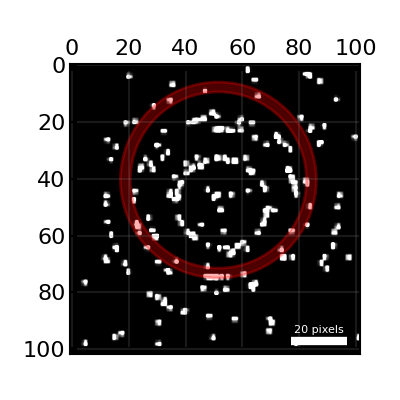

In [406]:
# We will measure the ellipticity by fitting one of the Bragg peak rings.
# First choose the radial range in q:
#q_range = (19, 21)
q_range = (31,34.5)

py4DSTEM.show(
    bragg_vector_map_centered,
    intensity_range='absolute',
    vmin=0,
    vmax=1e3,
    annulus={
        'center':tuple(np.array(bragg_peaks_masked.calibration.get_origin_mean())/10),
        'radii': q_range,
        'fill':True,
        'color':'r',
        'alpha':0.3
    },
    figsize = (4,4),
    #ticks = False,
)

[########################################] | 100% Completed | 100.65 ms
[########################################] | 100% Completed | 100.69 ms
s_shifts [ 38.  -25.5]


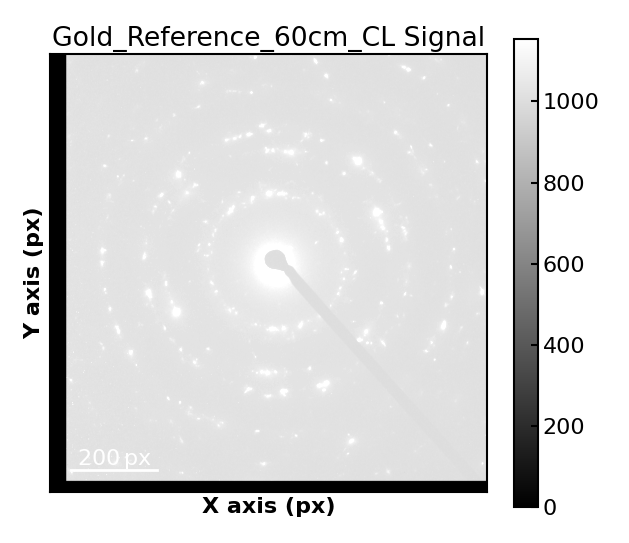

In [129]:
## load the data
fullFileName = os.path.join(fp, goldReferenceList[0])
referenceImage = hs.load(fullFileName)


#set as diffraction data
referenceImage.set_signal_type('diffraction')

#shift center for radial profile
s_shifts = referenceImage.get_direct_beam_position(method='interpolate', sigma=10, upsample_factor=2, kind='cubic')
# s_shifts = referenceImage.get_direct_beam_position(method='blur', sigma=20)
#readout for now
# s_shifts = [38 -25]
referenceImage.center_direct_beam(shifts=s_shifts)
print('s_shifts', s_shifts.data)


# ## needs input of center, use average center for now --> should not move a lot
# referenceImage.subtract_diffraction_background(
#     method='radial median',
#     center_x=referenceImage.axes_manager[0].size/2,
#     center_y = referenceImage.axes_manager[1].size/2,
#     inplace=True,

# )

# backgroundSubstractedDataRadialMedian.plot(navigator_kwds={'cmap':'turbo'}, cmap='turbo')


# #plot the stack 
referenceImage.plot(vmax='99th')

In [412]:
bragg_peaks_masked.calstate

{'center': True, 'ellipse': False, 'pixel': False, 'rotate': False}

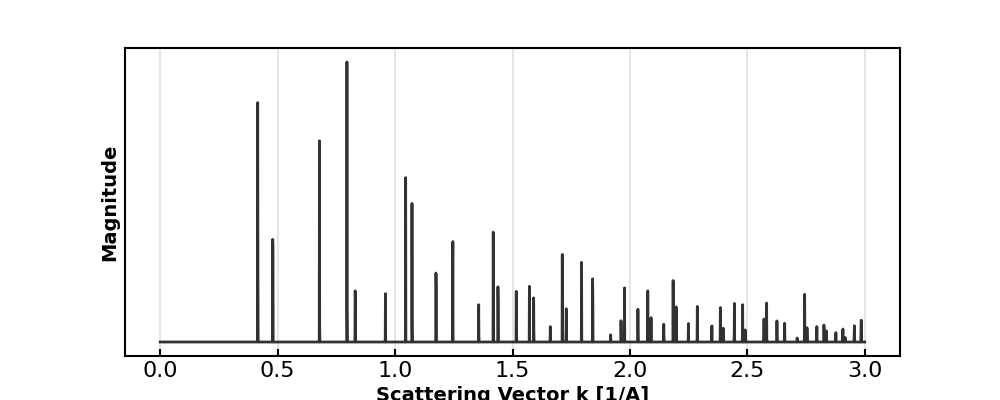

In [415]:
# Compare measured diffraction pattern with reference crystal structure
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 1.0,
)

In [131]:
s_shifts = pyxem.signals.BeamShift

NameError: name 'pyxem' is not defined

## calibrate

In [423]:
## Additional Functions: 
#Gaussian smooth 
def gaussian_filter1d(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter
    
def gauss_smooth(signal,sigma,size = None):
    if size is None:
        size = int(8*sigma)
    return np.convolve(signal, gaussian_filter1d(size,sigma), mode='same')

factor: 0.0045


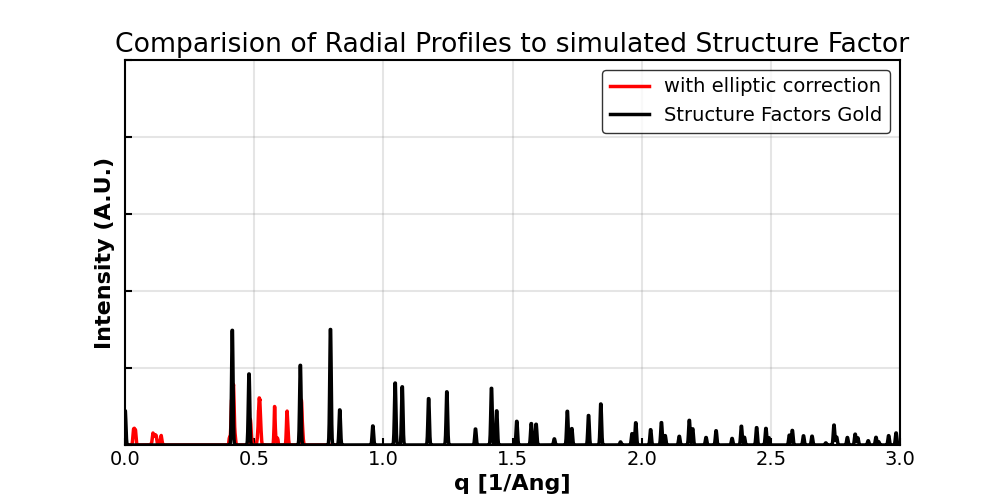

In [459]:
# Calculate and plot the radial integral
ymax = 1e8

q_corr_factor = 0.00450 # 150cm 
# q_corr_factor = 0.00540 # 120cm 
# q_corr_factor = 0.00658 # 100cm 
# q_corr_factor = 0.00845 # 80cm 
# q_corr_factor = 0.0106 # 60cm
# q_corr_factor = 0.0127 # 50cm 
# q_corr_factor = 0.0149 # 40cm 
# q_corr_factor = 0.0195 # 30cm 
# q_corr_factor = 0.0280 # 25cm
# q_corr_factor = 0.08 # 20cm 
intensityFactorBragg = 2

centerBraggPeaks = bragg_peaks_masked.calibration.get_origin_mean()

q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    # bragg_vector_map_centered,
    bragg_vector_map_masked,
    # x0=centerBraggPeaks[0]/10,
    # y0=centerBraggPeaks[1]/10,
    # x0=53.1,
    # y0=46.9,
    # x0=46.9,
    # y0=53.1,

    x0=center_guess[0],
    y0=center_guess[1],
)

fig,ax = py4DSTEM.visualize.show_qprofile(
    q = q*q_corr_factor,
    intensity = intensity_radial * q*intensityFactorBragg,
    ymax = ymax,
    xlabel = 'q [1/Ang]',
    color='r',
    figsize=(10, 5),
    label = 'with elliptic correction',
    returnfig=True,
)

## add gold comparision

ymax = 10000000


intensityFactor = 3

## Gold
q_SF = np.linspace(0,k_max,crystal.g_vec_leng.shape[0])
I_SF = np.zeros_like(q_SF)
for a0 in range(crystal.g_vec_leng.shape[0]):
    if np.abs(crystal.g_vec_all[2,a0]) < 1000:
        idx = np.argmin(np.abs(q_SF-crystal.g_vec_leng[a0]))
        I_SF[idx] += crystal.struct_factors_int[a0]

I_SF = gauss_smooth(I_SF,2)
I_SF /= np.max(I_SF)/intensityFactor

ax.plot(q_SF,I_SF*ymax,c='k',label='Structure Factors Gold')
ax.set_xlim([0, k_max])
plt.title('Comparision of Radial Profiles to simulated Structure Factor')
plt.legend()

print("factor:", q_corr_factor)

In [460]:
## create list with calibration values
from math import nan
# Base dictionary - in px/Ang - 256x256 images (used binning) - do not use 20cm anyway :D 
cameraLengthDict = {
    "20cm": 0.08, # maybe 
    "25cm": 0.0280, 
    "30cm": 0.0195, 
    "40cm": 0.0149, 
    "50cm": 0.0127, 
    "60cm": 0.0106, 
    "80cm": 0.00845, 
    "100cm": 0.00658, 
    "120cm": 0.00540, 
    "150cm": 0.00450,
}

cameraLengthDict["60cm"]

0.0106

In [20]:
1/(0.839/2)
1/(0.9706/2)

2.06058108386565

In [23]:
##measurements Si

1/(0.7321/2) #002
# 1/(0.6327/2) #111

2.7318672312525614

In [468]:
1/(1.4178/2)

1.4106361969248131

In [1]:
1/(1.1855/2)

1.687051876845213

In [4]:
1/(1.4125/2)



1.415929203539823

In [19]:
## GaS

1/(0.241/2) #002
1/(0.4873/2) #004
1/(0.731/2) #006
1/(0.9623/2) #008

2.078353943676608

In [6]:
2.7318672312525614/1.415929203539823

1.9293812320721215

In [7]:
0.0106/1.9293812320721215

0.0054939893805309725

In [8]:
0.00540/2

0.0027